In [1]:
import pandas as pd

# CSV dosyasını oku
df = pd.read_csv("logs.csv")

# Yeni sütun ekle ve tüm satırlara 0 ata
df["suspicious"] = 0

# Kontrol için ilk 5 satırı yazdır
print(df.head())

# İstersen tekrar CSV olarak kaydet
df.to_csv("veri_sus.csv", index=False)


   ID001 ID001.1  UNKNOWN     FOE  36.34612057984622  32.456597696536534  697  \
0  ID002   ID002     LK58  FRIEND          38.344042           33.489699  413   
1  ID003   ID003     FD24  FRIEND          36.067220           34.668448  835   
2  ID004   ID004     SJ84  FRIEND          39.081307           33.903840  498   
3  ID005   ID005     AW95  FRIEND          36.564391           39.773500  283   
4  ID006   ID006  UNKNOWN     FOE          36.797733           36.940877  413   

   1329  3910    351  suspicious  
0  2325   594  248.0           0  
1   740  5892    2.0           0  
2  4361  9466  147.0           0  
3  2108  7403   69.0           0  
4  1811  1145  305.0           0  


In [2]:
import pandas as pd

# CSV'yi oku
df = pd.read_csv("veri_sus.csv", header=None)

# Kolon isimleri verelim (okunabilirlik için)
df.columns = ["id1", "id2", "callsign", "friend_foe", "lat", "lon", "speed", "baroAltitude", "geoAltitude", "heading", "suspicious"]

# Önce tüm satırlara 0 ata
df["suspicious"] = 0

# Veriyi id1'e göre gruplayıp, her grup içinde önceki değerleri hesaplayalım
df = df.sort_values(by=['id1', 'id2'])  # id2'nin zaman sırasını verdiğini varsayıyorum, yoksa index sırasına göre de olabilir.

# Önceki değerleri hesapla
df['prev_speed'] = df.groupby('id1')['speed'].shift(1)
df['prev_baroAltitude'] = df.groupby('id1')['baroAltitude'].shift(1)
df['prev_heading'] = df.groupby('id1')['heading'].shift(1)

# FOE olanları seç
foe_mask = df['friend_foe'] == 'FOE'

# Kural 1: Hız değişimi %10'dan fazla ise
rule1 = (df['speed'] - df['prev_speed']).abs() / df['prev_speed'] > 0.10
# NaN değerler için False döndürmek gerek, çünkü ilk kayıtlarda önceki değer yok.
rule1 = rule1.fillna(False)

# Kural 2: baroAltitude değişimi 1000 fitten fazla ise
rule2 = (df['baroAltitude'] - df['prev_baroAltitude']).abs() > 1000
rule2 = rule2.fillna(False)

# Kural 3: heading değişimi 45 dereceden fazla ise
# Heading değişimini hesaplarken, 360 derecelik döngüyü de dikkate almak gerekebilir.
# Örneğin, 1 dereceden 359 dereceye geçişte mutlak fark 358 derece olur, ama aslında 2 derecelik bir değişimdir.
# Bu nedenle, heading farkını hesaplamak için: 
# diff = abs(heading - prev_heading)
# diff = min(diff, 360 - diff)
def heading_diff(h1, h2):
    diff = abs(h1 - h2)
    return min(diff, 360 - diff)

# Vectorized işlem için fonksiyonu uygulayamayız, apply kullanabiliriz ama büyük veri için yavaş olur.
# Alternatif: 
diff = abs(df['heading'] - df['prev_heading'])
rule3 = diff > 45
rule3 = rule3 & (360 - diff > 45)  # Bu şekilde değil, çünkü 360-diff her zaman diff'ten büyük olmayabilir.
# Doğrusu: 
rule3 = diff.apply(lambda x: min(x, 360-x)) > 45
# Ama bu şekilde vectorized değil. Daha hızlı bir yol:
diff = abs(df['heading'] - df['prev_heading'])
rule3 = pd.Series([min(d, 360-d) for d in diff], index=diff.index) > 45
rule3 = rule3.fillna(False)

# Kural 4: geoAltitude < 100
rule4 = df['geoAltitude'] < 100

# Kural 5: speed > 900
rule5 = df['speed'] > 900

# Tüm kuralları birleştir: rule1 veya rule2 veya rule3 veya rule4 veya rule5
suspicious_rules = rule1 | rule2 | rule3 | rule4 | rule5

# Sadece FOE olanlar ve kurallardan biri sağlanıyorsa suspicious=1 yap
df.loc[foe_mask & suspicious_rules, 'suspicious'] = 1

# Ara sütunları sil
df.drop(columns=['prev_speed', 'prev_baroAltitude', 'prev_heading'], inplace=True)

# Kaydet
df.to_csv("veri_labeled.csv", index=False)

In [15]:
import pandas as pd

# Veriyi yükle
df = pd.read_csv("veri_labeled.csv")

# Her bir id1 için suspicious değerlerinin yüzdesini hesapla
suspicious_stats = df.groupby('id1')['suspicious'].agg([
    ('total_observations', 'count'),
    ('suspicious_count', 'sum'),
    ('suspicious_percentage', lambda x: (x.sum() / x.count()) * 100)
]).round(2)

# Sonuçları göster
print("Her bir uçak ID'si için şüpheli hareket yüzdeleri:")
print(suspicious_stats)

# İsterseniz bu istatistikleri CSV olarak kaydedin
suspicious_stats.to_csv("suspicious_statistics.csv")

Her bir uçak ID'si için şüpheli hareket yüzdeleri:
       total_observations  suspicious_count  suspicious_percentage
id1                                                               
ID001                 206                29                  14.08
ID002                 206                 0                   0.00
ID003                 206                 0                   0.00
ID004                 206                 0                   0.00
ID005                 206                 0                   0.00
ID006                 206                34                  16.50
ID007                 206                 0                   0.00
ID008                 206                 0                   0.00
ID009                 206                 0                   0.00
ID010                 206                 0                   0.00
ID011                 206               206                 100.00
ID012                 206               206                 100.00
ID013      

Veri seti boyutu: (4532, 11)

İlk 5 satır:
     id1    id2 callsign friend_foe        lat        lon  speed  \
0  ID001  ID001  UNKNOWN        FOE  36.366448  32.455888    678   
1  ID001  ID001  UNKNOWN        FOE  36.386986  32.455171    685   
2  ID001  ID001  UNKNOWN        FOE  36.407613  32.454450    688   
3  ID001  ID001  UNKNOWN        FOE  36.427999  32.450856    690   
4  ID001  ID001  UNKNOWN        FOE  36.447366  32.443807    687   

   baroAltitude  geoAltitude  heading  suspicious  
0          1295         3876    358.0           0  
1          1295         3876    358.0           0  
2          1295         3876    358.0           0  
3          1314         3895    350.0           0  
4          1308         3889    340.0           0  

Sütunlar ve veri tipleri:
id1              object
id2              object
callsign         object
friend_foe       object
lat             float64
lon             float64
speed             int64
baroAltitude      int64
geoAltitude      

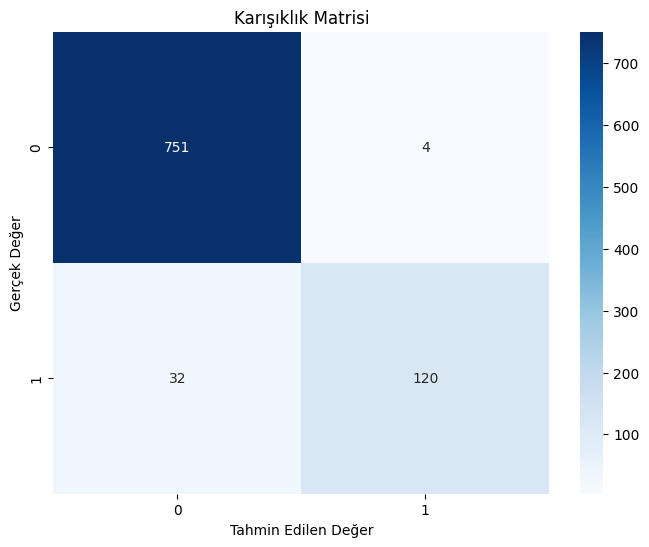

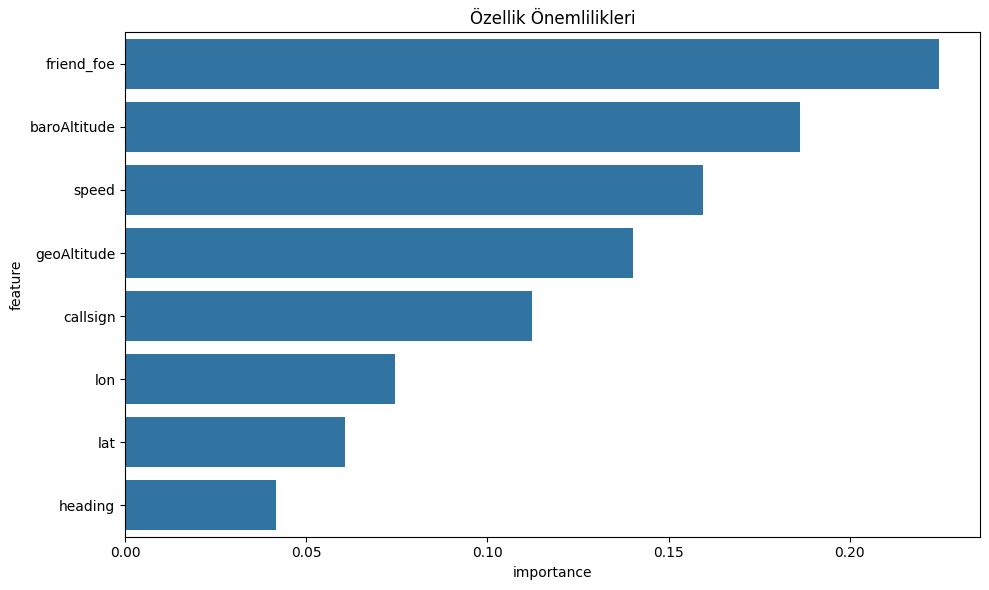


Özellik Önemlilikleri:
        feature  importance
1    friend_foe    0.224741
5  baroAltitude    0.186399
4         speed    0.159585
6   geoAltitude    0.140174
0      callsign    0.112316
3           lon    0.074436
2           lat    0.060585
7       heading    0.041764

Model ve ön işleme nesneleri başarıyla kaydedildi.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Veriyi yükleme
df = pd.read_csv("veri_labeled.csv")

# 2. Veriyi inceleme
print("Veri seti boyutu:", df.shape)
print("\nİlk 5 satır:")
print(df.head())
print("\nSütunlar ve veri tipleri:")
print(df.dtypes)
print("\nEksik değerler:")
print(df.isnull().sum())
print("\nSınıf dağılımı (suspicious):")
print(df['suspicious'].value_counts())

# 3. Ön işleme

# Kategorik değişkenleri sayısallaştırma
label_encoders = {}
categorical_cols = ['callsign', 'friend_foe']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"{col} için kodlama: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Özellikler ve hedef değişkeni ayırma
X = df.drop(['id1', 'id2', 'suspicious'], axis=1)  # Özellikler
y = df['suspicious']  # Hedef değişken

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Özellikleri ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Model eğitimi
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# 5. Model değerlendirme
y_pred = model.predict(X_test_scaled)

print("\nModel Doğruluğu:", accuracy_score(y_test, y_pred))
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Karışıklık Matrisi')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.savefig('confusion_matrix.png')
plt.show()

# 6. Özellik önemlilikleri
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Özellik Önemlilikleri')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

print("\nÖzellik Önemlilikleri:")
print(feature_importance)

# 7. Modeli kaydetme
import joblib
joblib.dump(model, 'uçak_davranış_modeli.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("\nModel ve ön işleme nesneleri başarıyla kaydedildi.")